In [1]:
# 1️⃣ Setup & Imports
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch.utils.data import IterableDataset, DataLoader, get_worker_info
import json, random, tempfile, imageio
from IPython.display import Image, display
from math import ceil
from collections import Counter
# Display inline
%matplotlib inline

# ──────────────────────────────────────────────────────────────────
#  CONFIGURATION
# ──────────────────────────────────────────────────────────────────
ROOT          = Path("/Users/julianquast/Documents/Bachelor Thesis/Datasets/rearrange_10k_v1")
META_FILE     = ROOT / "metadata.json"
EPISODES_DIR  = ROOT / "episodes"
OBS_SHAPE     = (224, 224, 3)   # H, W, C
T_CLIP        = 5              # clip length (frames)
EPOCH_SAMPLES = 2000            # clips per epoch
BATCH_SIZE    = 32
NUM_WORKERS   = 4
SEED          = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)


In [2]:
# 2️⃣ Load metadata & verify folders
with open(META_FILE) as f:
    meta = json.load(f)
df_meta = pd.DataFrame(meta["episodes"])

print(f"📦 Metadata lists {len(df_meta)} episodes")

folders = sorted(EPISODES_DIR.glob("ep_*"))
print(f"📂 Found {len(folders)} episode folders")

assert len(folders) == len(df_meta), "Metadata / folder-count mismatch!"


📦 Metadata lists 147 episodes
📂 Found 147 episode folders


In [74]:
# # 🧹 Trim last frame from action.npy and obs.npy in each episode folder
# for ep_folder in sorted(EPISODES_DIR.glob("ep_*")):
#     action_path = ep_folder / "actions.npy"
#     obs_path = ep_folder / "obs.npy"
    
#     if action_path.exists() and obs_path.exists():
#         actions = np.load(action_path)
#         obs = np.load(obs_path)
        
#         # Sanity check: obs should be one element longer than actions (because it includes s_0 to s_T)
#         if len(obs) != len(actions) + 1:
#             print(f"⚠️ Skipping {ep_folder.name}: unexpected shape (obs: {len(obs)}, action: {len(actions)})")
#             continue
        
#         # Trim last element
#         np.save(action_path, actions[:-1])
#         np.save(obs_path, obs[:-1])
#     else:
#         print(f"⚠️ Missing files in {ep_folder}")
# print("✅ All episode files processed.")


In [3]:
# 🔍 Check that all episode files now have equal lengths for obs and action
mismatches = []
for ep_folder in sorted(EPISODES_DIR.glob("ep_*")):
    action_path = ep_folder / "action.npy"
    obs_path = ep_folder / "obs.npy"
    
    if action_path.exists() and obs_path.exists():
        actions = np.load(action_path)
        obs = np.load(obs_path)
        
        if len(obs) != len(actions):
            mismatches.append((ep_folder.name, len(obs), len(actions)))

if mismatches:
    print(f"❌ {len(mismatches)} mismatches found:")
    for name, o, a in mismatches:
        print(f" - {name}: obs={o}, actions={a}")
else:
    print("✅ All episode files have matching obs and action lengths.")


✅ All episode files have matching obs and action lengths.


In [76]:
# # 📄 Adjust metadata.json after trimming last frame from each episode
# with open(META_FILE) as f:
#     meta = json.load(f)

# updated = 0
# for entry in meta["episodes"]:
#     if entry["n_actions"] > 0 and entry["n_observations"] > 0:
#         entry["n_actions"] -= 1
#         entry["n_observations"] -= 1
#         updated += 1
#     else:
#         print(f"⚠️ Episode {entry['episode']:04d} has non-positive values — skipped.")

# # Save updated metadata
# with open(META_FILE, "w") as f:
#     json.dump(meta, f, indent=2)

# print(f"✅ Updated metadata for {updated} episodes and saved to {META_FILE.name}")


In [4]:
# 3️⃣ Structural checks: obs.npy + actions.npy
errors = []
for _, ep in df_meta.iterrows():
    eid = int(ep["episode"])
    n_act = int(ep["n_actions"])
    n_obs = int(ep["n_observations"])
    folder = EPISODES_DIR / f"ep_{eid:04d}"

    # paths
    act_path = folder / "actions.npy"
    obs_path = folder / "obs.npy"

    # existence
    if not act_path.exists():
        errors.append(f"Ep{eid:04d}: missing actions.npy")
        continue
    if not obs_path.exists():
        errors.append(f"Ep{eid:04d}: missing obs.npy")
        continue

    # load
    act = np.load(act_path, mmap_mode="r")
    obs = np.load(obs_path, mmap_mode="r")

    # shape checks
    if act.shape[0] != n_act:
        errors.append(f"Ep{eid:04d}: actions length {act.shape[0]} != {n_act}")
    if obs.shape[0] != n_obs:
        errors.append(f"Ep{eid:04d}: obs length {obs.shape[0]} != {n_obs}")
    if obs.shape[1:] != OBS_SHAPE:
        errors.append(f"Ep{eid:04d}: obs shape {obs.shape[1:]} != {OBS_SHAPE}")
    if obs.shape[0] != act.shape[0] + 1:
        errors.append(f"Ep{eid:04d}: obs != actions+1 ({obs.shape[0]} vs {act.shape[0]+1})")

    # dtype/range
    if act.dtype != np.int32 and not np.issubdtype(act.dtype, np.integer):
        errors.append(f"Ep{eid:04d}: actions dtype {act.dtype}")
    if obs.dtype != np.uint8:
        errors.append(f"Ep{eid:04d}: obs dtype {obs.dtype}")

# report
if errors:
    print("❌ Structural errors:")
    for e in errors[:10]:
        print("  ", e)
    if len(errors)>10: print("  ...")
else:
    print("✅ All episodes have valid obs.npy & actions.npy!")


✅ All episodes have valid obs.npy & actions.npy!


,count,mean,std,min,25%,50%,75%,max
n_actions,147.0,142.755102,21.693251,98.0,126.0,142.0,154.0,253.0
n_observations,147.0,143.755102,21.693251,99.0,127.0,143.0,155.0,254.0
obs_minus_actions,147.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0


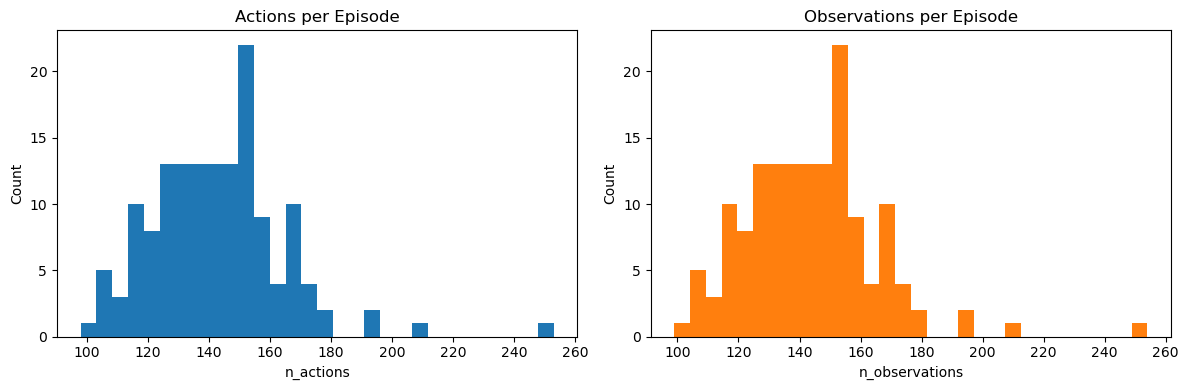

In [5]:
# 4️⃣ DataFrame & stats
df = df_meta.copy()
df["obs_minus_actions"] = df["n_observations"] - df["n_actions"]

# summary
display(df[["n_actions","n_observations","obs_minus_actions"]].describe().T)

# histograms
fig, axs = plt.subplots(1,2, figsize=(12,4))
axs[0].hist(df["n_actions"], bins=30)
axs[0].set(title="Actions per Episode", xlabel="n_actions", ylabel="Count")
axs[1].hist(df["n_observations"], bins=30, color="C1")
axs[1].set(title="Observations per Episode", xlabel="n_observations", ylabel="Count")
plt.tight_layout()


Action values range: 0 … 5
Action Value Distribution:
  Action 0: 5170
  Action 1: 6999
  Action 2: 8522
  Action 4: 147
  Action 5: 147


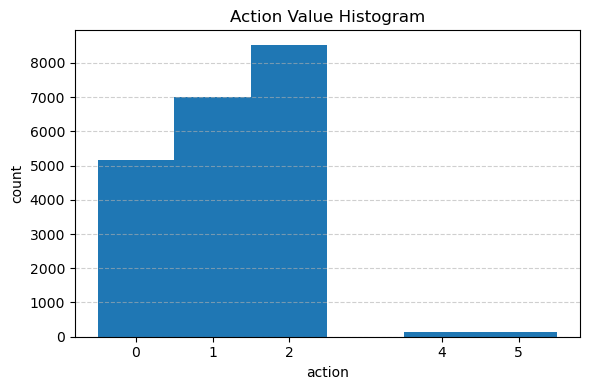

In [6]:
# 5️⃣ Aggregate all actions to inspect discrete range
all_actions = []
for eid in df["episode"]:
    arr = np.load(EPISODES_DIR / f"ep_{eid:04d}" / "actions.npy", mmap_mode="r")
    all_actions.append(arr)
all_actions = np.concatenate(all_actions)

# Print range
print(f"Action values range: {all_actions.min()} … {all_actions.max()}")

# Compute histogram
action_vals, counts = np.unique(all_actions, return_counts=True)

# Print distribution
print("Action Value Distribution:")
for val, count in zip(action_vals, counts):
    print(f"  Action {val}: {count}")

# Plot histogram
plt.figure(figsize=(6, 4))
plt.hist(all_actions, bins=np.arange(all_actions.min(), all_actions.max() + 2) - 0.5)
plt.title("Action Value Histogram")
plt.xlabel("action")
plt.ylabel("count")
plt.xticks(action_vals)
plt.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()



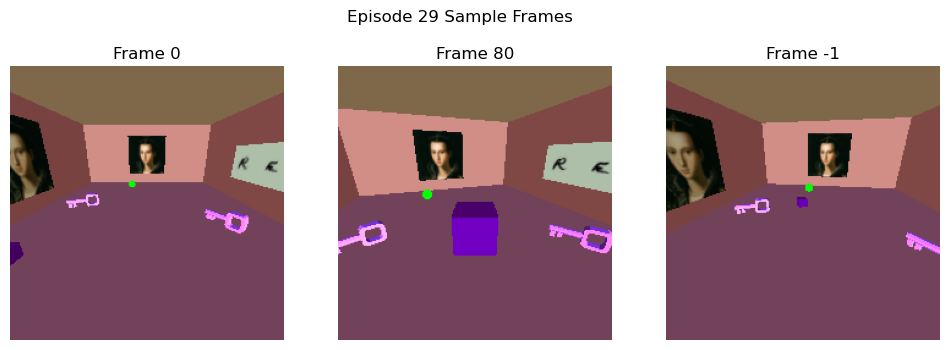

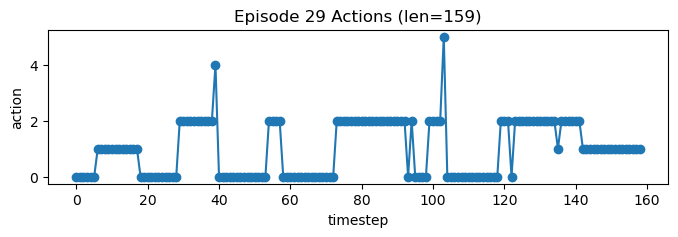

In [7]:
# 6️⃣ Visualize random episode: frames & its actions sequence
eid = random.choice(df["episode"].tolist())
folder = EPISODES_DIR / f"ep_{eid:04d}"
obs = np.load(folder/"obs.npy", mmap_mode="r")
act = np.load(folder/"actions.npy", mmap_mode="r")

# show frames
fig, axs = plt.subplots(1,3, figsize=(12,4))
for i, idx in enumerate([0, len(obs)//2, -1]):
    axs[i].imshow(obs[idx])
    axs[i].set_title(f"Frame {idx}")
    axs[i].axis("off")
plt.suptitle(f"Episode {eid} Sample Frames")
plt.show()

# show actions
plt.figure(figsize=(8,2))
plt.plot(act, marker='o', linestyle='-')
plt.title(f"Episode {eid} Actions (len={len(act)})")
plt.xlabel("timestep")
plt.ylabel("action")
plt.show()


▶️ Playing Episode 7 (144 frames) as GIF


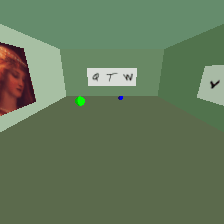

In [8]:
# 9️⃣ Visualize a random episode as an inline GIF
# Load episode IDs
with open(META_FILE) as f:
    ep_list = [int(ep["episode"]) for ep in json.load(f)["episodes"]]

# Pick a random episode
eid = random.choice(ep_list)
folder = EPISODES_DIR / f"ep_{eid:04d}"
obs = np.load(folder / "obs.npy", mmap_mode="r")
print(f"▶️ Playing Episode {eid} ({obs.shape[0]} frames) as GIF")

# Write to temporary GIF
tmp = tempfile.NamedTemporaryFile(suffix=".gif", delete=False)
imageio.mimsave(tmp.name, [frame for frame in obs], fps=10)

# Display GIF inline
display(Image(tmp.name))

🎲 Episode 71: 172 observations, 171 actions


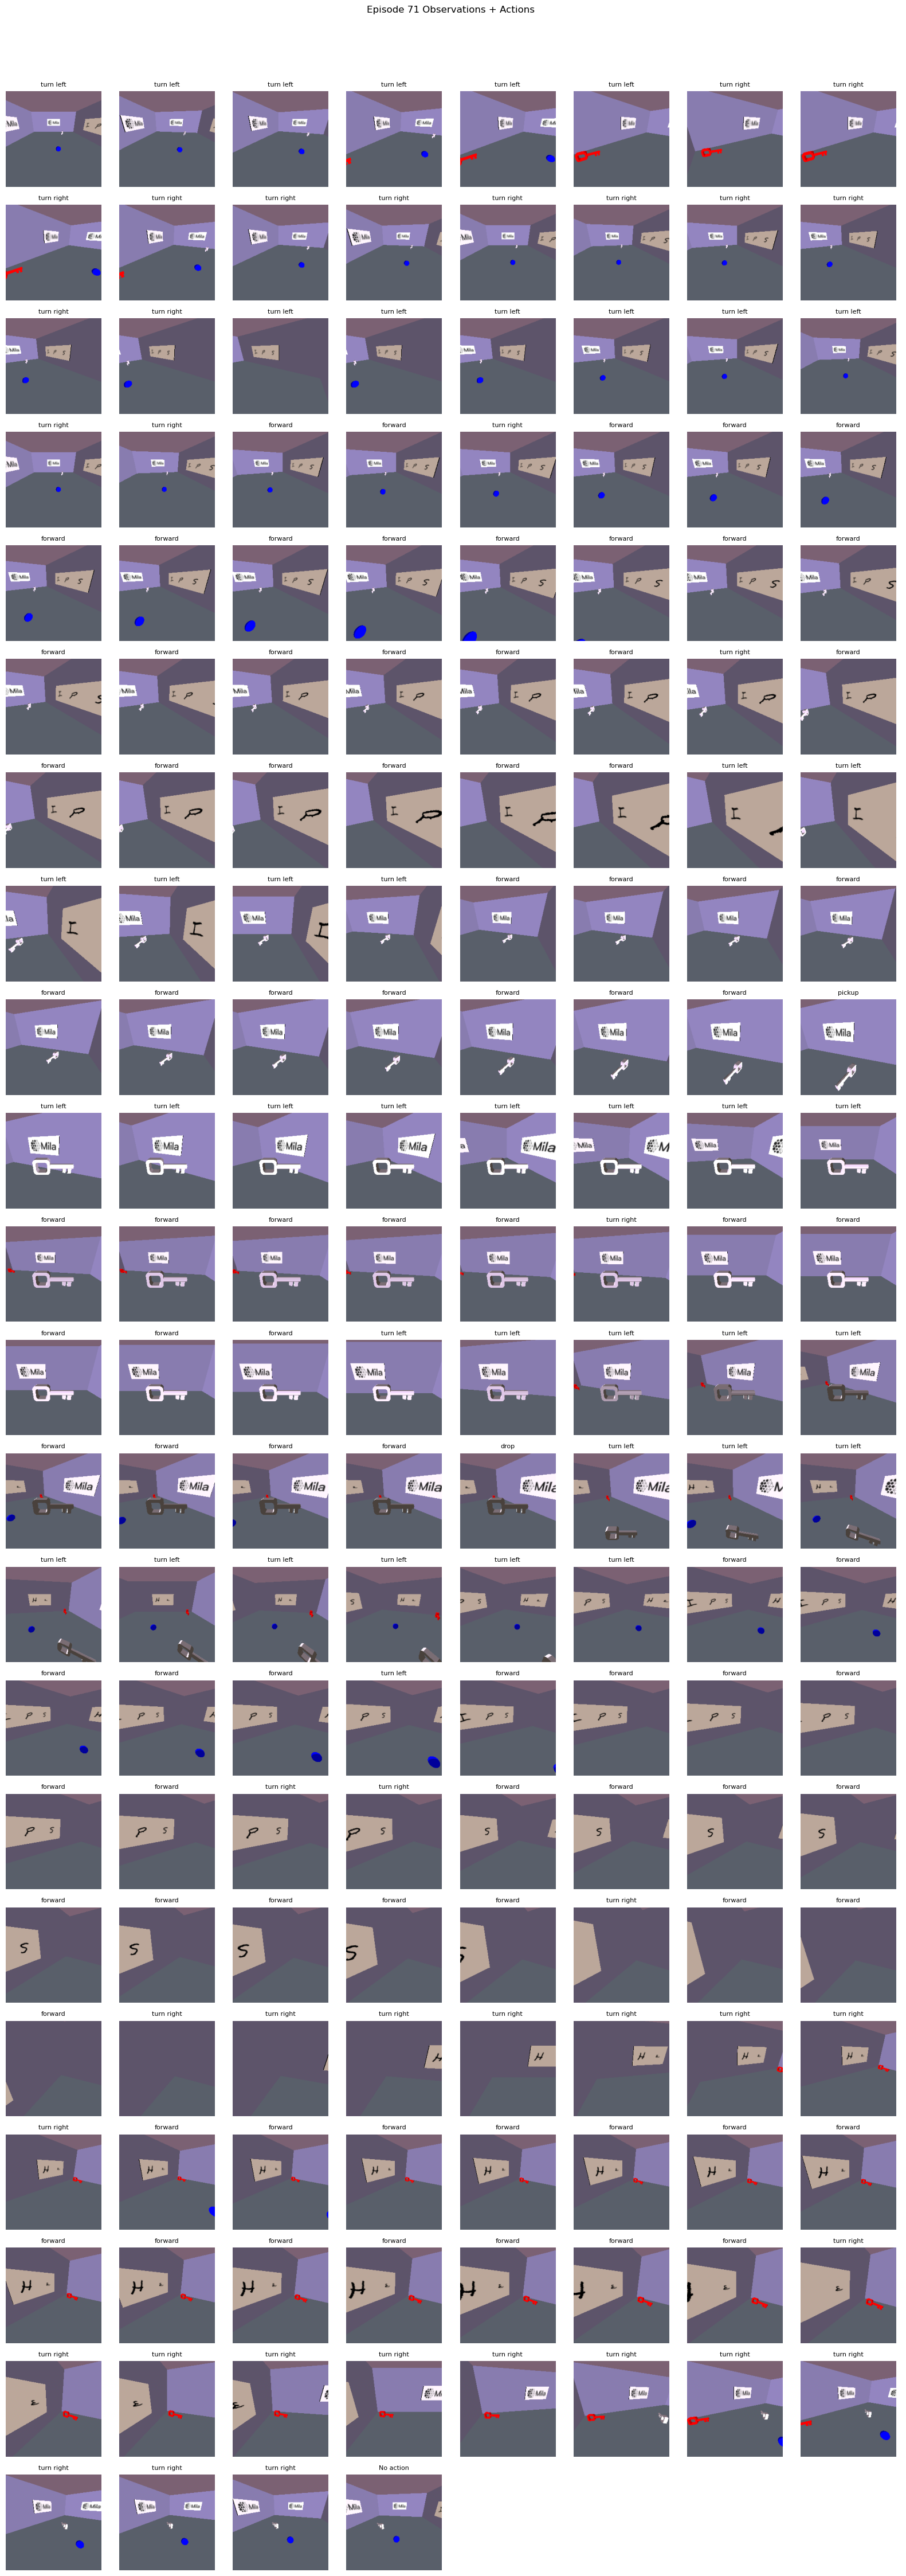

In [9]:
# 🔄 10. Display All Observations + Corresponding Actions for a Random Episode
# Action mapping
action_map = {
    0: "turn left",
    1: "turn right",
    2: "forward",
    4: "pickup",
    5: "drop",
    7: "done"
}

# Load episode IDs
with open(META_FILE) as f:
    ep_list = [int(ep["episode"]) for ep in json.load(f)["episodes"]]

# Pick a random episode
eid = random.choice(ep_list)
folder = EPISODES_DIR / f"ep_{eid:04d}"
obs = np.load(folder / "obs.npy", mmap_mode="r")
act = np.load(folder / "actions.npy", mmap_mode="r")

n_obs = obs.shape[0]
n_act = act.shape[0]
print(f"🎲 Episode {eid}: {n_obs} observations, {n_act} actions")

# Determine grid size (max 8 columns)
cols = min(8, n_obs)
rows = ceil(n_obs / cols)

fig, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))
axes = axes.flatten()

for i, ax in enumerate(axes):
    if i < n_obs:
        ax.imshow(obs[i])
        if i < n_act:
            label = action_map.get(int(act[i]), f"unk:{act[i]}")
            ax.set_title(f"{label}", fontsize=8)
        else:
            ax.set_title("No action", fontsize=8)
    ax.axis('off')

plt.suptitle(f"Episode {eid} Observations + Actions", y=1.02)
plt.tight_layout()
plt.show()

In [83]:
# ───────────────────────────────────────────────────────────────────
# Re-build action→positions index (same as before)
# ───────────────────────────────────────────────────────────────────
ep_lens = {ep["episode"]: ep["n_observations"] for ep in meta["episodes"]}
def build_action_index(ep_ids, episodes_dir):
    idx = {}
    for eid in ep_ids:
        acts = np.load(episodes_dir/f"ep_{eid:04d}/actions.npy", mmap_mode="r")
        for pos, a in enumerate(acts):
            idx.setdefault(int(a), []).append((eid, pos))
    return idx

ep_ids       = list(ep_lens.keys())
action_index = build_action_index(ep_ids, EPISODES_DIR)

# ───────────────────────────────────────────────────────────────────
# Stratified Dataset with action at window’s last slot
# ───────────────────────────────────────────────────────────────────
class StratifiedLastActionDataset(IterableDataset):
    def __init__(self, action_index, ep_lens, ep_dir, T, n_samples, base_seed=0):
        self.action_index = action_index
        self.actions_list = list(action_index)
        self.ep_lens      = ep_lens
        self.ep_dir       = Path(ep_dir)
        self.T            = T
        self.n_samples    = n_samples
        self.base_seed    = base_seed

    def _init_worker(self):
        info = get_worker_info()
        seed = self.base_seed + (info.id if info else 0)
        random.seed(seed)
        np.random.seed(seed)
        self._memmap = {}

    def _get_memmap(self, eid):
        if eid not in self._memmap:
            self._memmap[eid] = np.load(self.ep_dir/f"ep_{eid:04d}/obs.npy", mmap_mode="r")
        return self._memmap[eid]

    def __iter__(self):
        self._init_worker()
        count = 0
        while count < self.n_samples:
            # 1) sample action class uniformly
            a = random.choice(self.actions_list)

            # 2) pick one occurrence (episode, position)
            eid, pos = random.choice(self.action_index[a])
            N = self.ep_lens[eid]
            # ───────────────────────────────────────────────────────────
            # 3) compute window so that obs[pos+1] is clip[T-1]
            # ───────────────────────────────────────────────────────────
            end   = pos + 2              # index of the obs _after_ the action
            start = end - self.T         # so that last obs = end
            # clamp into valid range [0, N-T]
            start = max(0, min(start, N - self.T))

            # 4) load & slice obs
            buf  = self._get_memmap(eid)
            clip = buf[start : start + self.T].astype(np.float32) / 255.0
            clip = torch.from_numpy(clip).permute(0,3,1,2)  # (T, C, H, W)

            # 5) emit (clip, action) where action=a corresponds to clip[T-1]
            yield clip, a
            count += 1

    def __len__(self):
        return self.n_samples

# ───────────────────────────────────────────────────────────────────
# Instantiate & DataLoader
# ───────────────────────────────────────────────────────────────────
strat_ds = StratifiedLastActionDataset(
    action_index, ep_lens, EPISODES_DIR, T_CLIP, EPOCH_SAMPLES, SEED
)
strat_loader = DataLoader(
    strat_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,      # already stratified
    num_workers=0,      # notebook‐safe
    pin_memory=False,
)

# quick sanity-check
clips, actions = next(iter(strat_loader))
print("clips:", clips.shape)      # (B, T, C, H, W)
print("actions:", actions.shape)  # (B,)



clips: torch.Size([32, 5, 3, 224, 224])
actions: torch.Size([32])


clips tensor shape : torch.Size([32, 5, 3, 224, 224])
actions tensor shape: torch.Size([32])


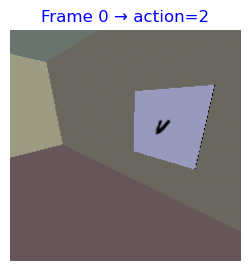

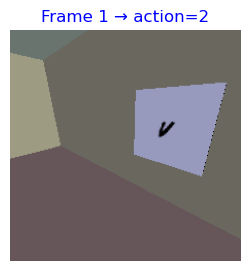

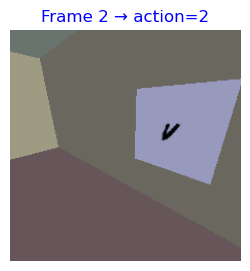

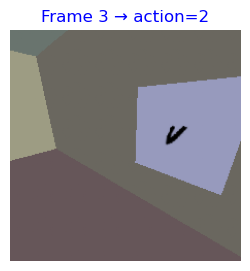

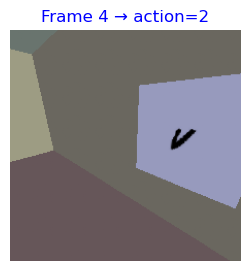

In [84]:
# 📺 8. Visualize Stratified Sampling Windows
# 1) Fetch one batch
clips, actions = next(iter(strat_loader))

# 2) Print tensor shapes
#    clips: (B, T, C, H, W), actions: (B,)
print(f"clips tensor shape : {clips.shape}")
print(f"actions tensor shape: {actions.shape}")

# 3) Take the first sample in the batch
clip   = clips[1]        # Tensor of shape (T, C, H, W)
action = actions[1].item()  # scalar label corresponding to clip[-1]

# 4) Loop over frames and display each
for t in range(clip.shape[0]):
    # convert (C, H, W) → (H, W, C) numpy array
    frame = clip[t].permute(1, 2, 0).cpu().numpy()
    
    plt.figure(figsize=(3,3))
    plt.imshow(frame)
    
    # title: show action only on last frame, or every frame as you prefer
    plt.title(f"Frame {t} → action={action}", color='blue')
   
    
    plt.axis('off')
    plt.show()

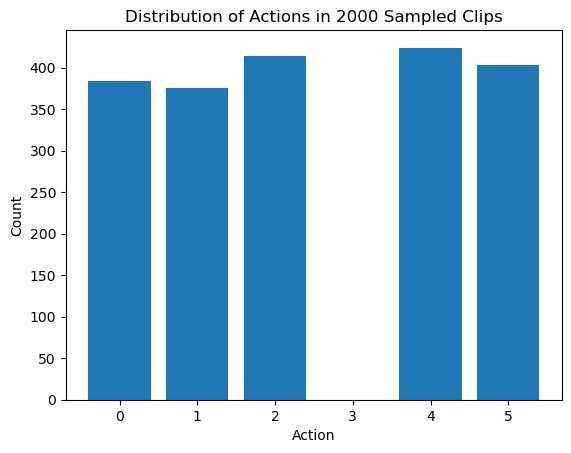

In [85]:
# 1) Build a dataset that will yield exactly 2000 samples
dataset_2000 = StratifiedLastActionDataset(
    action_index,    # your action→positions index
    ep_lens,         # dict of episode lengths
    EPISODES_DIR,    # root path to ep_{eid:04d}/obs.npy
    T_CLIP,          # clip length
    2000,            # number of samples to draw
    SEED             # base RNG seed
)

# 2) Iterate the dataset to collect all action labels
all_actions = []
for clip, a in dataset_2000:
    all_actions.append(int(a))

# 3) Compute the frequency of each action
action_counts = Counter(all_actions)
labels, counts = zip(*sorted(action_counts.items()))

# 4) Plot the distribution
plt.figure()
plt.bar(labels, counts)
plt.xlabel('Action')
plt.ylabel('Count')
plt.title('Distribution of Actions in 2000 Sampled Clips')
plt.show()